# Preprocessing Demo

This notebook demonstrates the three preprocessing modules in `timeseries_toolkit`:

1. **Fractional Differentiation** - Transform non-stationary series while preserving memory
2. **Time Series Filtering** - Two-stage STL + SARIMA noise removal
3. **Mixed-Frequency Imputation** - MICE-based imputation for irregular data

All examples use real market data fetched via the DataHub.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

print('Setup complete.')

Setup complete.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print('Plotting style configured.')

Plotting style configured.


## 1. Fetch Real Market Data

We use the `CryptoDataLoader` to fetch BTC-USD prices and the `EquityDataLoader` for SPY.

In [3]:
from timeseries_toolkit.data_sources import CryptoDataLoader, EquityDataLoader

crypto = CryptoDataLoader()
btc_df = crypto.get_prices(['BTC-USD'], period='2y')
btc_close = btc_df[[c for c in btc_df.columns if 'Close' in c or 'close' in c][0]]
btc_close.name = 'BTC-USD'
print(f'BTC-USD: {len(btc_close)} daily observations')
print(f'Range: {btc_close.index[0].date()} to {btc_close.index[-1].date()}')
print(f'Current price: ${btc_close.iloc[-1]:,.0f}')
btc_close.tail()

BTC-USD: 732 daily observations
Range: 2024-01-29 to 2026-01-29
Current price: $87,879


Date
2026-01-25    86572.218750
2026-01-26    88267.140625
2026-01-27    89102.570312
2026-01-28    89184.570312
2026-01-29    87879.125000
Name: BTC-USD, dtype: float64

In [4]:
equities = EquityDataLoader()
spy_df = equities.get_prices(['SPY'], period='2y')
spy_close = spy_df[[c for c in spy_df.columns if 'Close' in c or 'close' in c][0]]
spy_close.name = 'SPY'
print(f'SPY: {len(spy_close)} daily observations')
print(f'Range: {spy_close.index[0].date()} to {spy_close.index[-1].date()}')
print(f'Current price: ${spy_close.iloc[-1]:,.2f}')
spy_close.tail()

SPY: 502 daily observations
Range: 2024-01-29 to 2026-01-28
Current price: $695.42


Date
2026-01-22    688.979980
2026-01-23    689.229980
2026-01-26    692.729980
2026-01-27    695.489990
2026-01-28    695.419983
Name: SPY, dtype: float64

---
## 2. Fractional Differentiation

Standard differencing (d=1) makes a series stationary but destroys memory. Fractional differentiation uses a non-integer d (0 < d < 1) to achieve stationarity with minimal information loss.

### 2.1 Find Minimum d for Stationarity

In [5]:
from timeseries_toolkit.preprocessing import find_min_d_for_stationarity, frac_diff_ffd

min_d, results = find_min_d_for_stationarity(btc_close)
print(f'Minimum d for BTC-USD stationarity: {min_d:.2f}')
print()
print('ADF test results across d values:')
results.head(10)

Minimum d for BTC-USD stationarity: 0.90

ADF test results across d values:


,adf_stat,p_value,lags,nobs,critical_value,correlation
0.0,-2.110081,0.240480,0.0,731.0,-2.865502,1.000000
0.1,-2.185595,0.211515,2.0,722.0,-2.865551,0.999323
0.2,-1.959223,0.304733,6.0,715.0,-2.865591,0.994454
0.3,-1.899883,0.332116,12.0,708.0,-2.865631,0.980336
0.4,-1.976508,0.296968,12.0,709.0,-2.865625,0.954290
0.5,-2.160901,0.220741,12.0,710.0,-2.865619,0.905135
0.6,-2.438358,0.131201,12.0,711.0,-2.865614,0.818916
0.7,-2.695346,0.074847,12.0,713.0,-2.865602,0.724034
0.8,-2.864665,0.049614,16.0,710.0,-2.865619,0.549122
0.9,-3.458244,0.009127,16.0,712.0,-2.865608,0.393989


### 2.2 Apply Fractional Differentiation

Transform BTC prices using the minimum d found above.

In [6]:
btc_frame = pd.DataFrame({'BTC-USD': btc_close})
btc_ffd = frac_diff_ffd(btc_frame, d=min_d)

print(f'Original series length: {len(btc_close)}')
print(f'After frac diff (d={min_d:.2f}): {len(btc_ffd)} observations')
print(f'Observations lost: {len(btc_close) - len(btc_ffd)}')
print()

# Verify stationarity of the result
from statsmodels.tsa.stattools import adfuller
adf_stat, adf_pval, *_ = adfuller(btc_ffd.dropna().iloc[:, 0])
print(f'ADF test on fractionally differenced series:')
print(f'  Statistic: {adf_stat:.4f}')
print(f'  p-value:   {adf_pval:.6f}')
print(f'  Stationary: {adf_pval < 0.05}')

Original series length: 732
After frac diff (d=0.90): 608 observations
Observations lost: 124

ADF test on fractionally differenced series:
  Statistic: -22.6885
  p-value:   0.000000
  Stationary: True


### 2.3 Compare Original vs Fractionally Differenced

In [7]:
# Correlation between original and frac-diffed series
common_idx = btc_close.index.intersection(btc_ffd.index)
corr = btc_close.loc[common_idx].corr(btc_ffd.loc[common_idx].iloc[:, 0])
print(f'Correlation between original and frac-diffed (d={min_d:.2f}): {corr:.4f}')
print('(High correlation = memory preserved)')
print()

# Compare with full differencing
btc_diff1 = btc_close.diff().dropna()
corr_d1 = btc_close.iloc[1:].corr(btc_diff1)
print(f'Correlation between original and first difference (d=1): {corr_d1:.4f}')
print(f'Memory advantage of frac diff: {corr - corr_d1:.4f}')

Correlation between original and frac-diffed (d=0.90): 0.0745
(High correlation = memory preserved)

Correlation between original and first difference (d=1): 0.0192
Memory advantage of frac diff: 0.0553


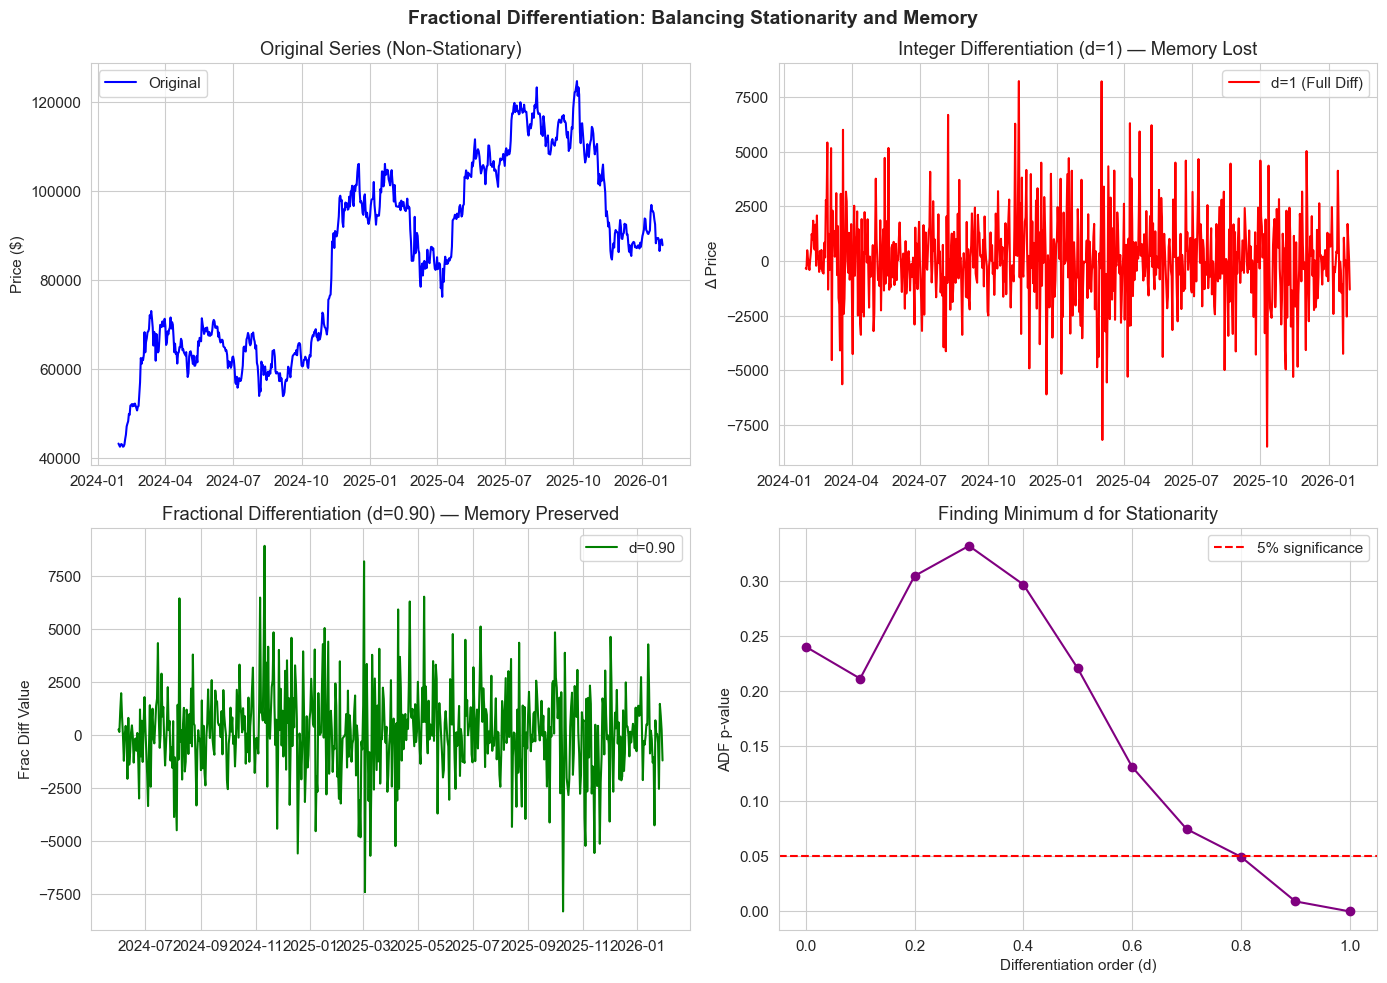

In [8]:
# ── Fractional Differentiation: 2x2 Comparison ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Original BTC prices
axes[0, 0].plot(btc_close, label='Original', color='blue')
axes[0, 0].set_title('Original Series (Non-Stationary)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()

# Top-right: Integer differencing (d=1)
btc_diff1_full = btc_close.diff().dropna()
axes[0, 1].plot(btc_diff1_full, label='d=1 (Full Diff)', color='red')
axes[0, 1].set_title('Integer Differentiation (d=1) — Memory Lost')
axes[0, 1].set_ylabel('Δ Price')
axes[0, 1].legend()

# Bottom-left: Fractional differencing (optimal d)
axes[1, 0].plot(btc_ffd, label=f'd={min_d:.2f}', color='green')
axes[1, 0].set_title(f'Fractional Differentiation (d={min_d:.2f}) — Memory Preserved')
axes[1, 0].set_ylabel('Frac Diff Value')
axes[1, 0].legend()

# Bottom-right: ADF p-values vs d
axes[1, 1].plot(results.index, results['p_value'], 'o-', color='purple')
axes[1, 1].axhline(y=0.05, color='r', linestyle='--', label='5% significance')
axes[1, 1].set_xlabel('Differentiation order (d)')
axes[1, 1].set_ylabel('ADF p-value')
axes[1, 1].set_title('Finding Minimum d for Stationarity')
axes[1, 1].legend()

plt.suptitle('Fractional Differentiation: Balancing Stationarity and Memory', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The top-left panel shows the original non-stationary BTC price series with a clear trend. Integer differentiation (top-right, d=1) achieves stationarity but destroys all memory of past price levels, producing pure noise-like changes. Fractional differentiation (bottom-left) with the optimal d achieves stationarity while preserving significantly more correlation with the original series. The bottom-right panel shows how the ADF test p-value decreases as d increases, with the optimal d being the minimum value that crosses the 5% significance threshold.

### 2.4 SPY: Same Analysis

In [9]:
min_d_spy, results_spy = find_min_d_for_stationarity(spy_close)
print(f'Minimum d for SPY stationarity: {min_d_spy:.2f}')

spy_frame = pd.DataFrame({'SPY': spy_close})
spy_ffd = frac_diff_ffd(spy_frame, d=min_d_spy)
print(f'After frac diff (d={min_d_spy:.2f}): {len(spy_ffd)} observations')

Minimum d for SPY stationarity: 0.90
After frac diff (d=0.90): 378 observations


---
## 3. Time Series Filtering

The `TimeSeriesFilter` applies a two-stage process:
1. **STL decomposition** to extract trend, seasonal, and residual components
2. **SARIMA** on residuals to capture remaining autocorrelation

### 3.1 Filter BTC Returns

In [10]:
from timeseries_toolkit.preprocessing import TimeSeriesFilter

# Work with returns (stationary) for filtering
btc_returns = btc_close.pct_change().dropna()

ts_filter = TimeSeriesFilter()
ts_filter.fit(btc_returns)
filtered = ts_filter.transform()
residuals = ts_filter.get_residuals()

print(f'Original returns: {len(btc_returns)} observations')
print(f'Filtered signal: {len(filtered)} observations')
print(f'Residuals (noise): {len(residuals)} observations')

Original returns: 731 observations
Filtered signal: 731 observations
Residuals (noise): 724 observations


### 3.2 Filter Quality Metrics

In [11]:
metrics = ts_filter.get_metrics()

print('Filter Quality Metrics:')
print(f'  SNR (dB):               {metrics["snr_db"]:.2f}')
print(f'  Variance (original):    {metrics["variance_original"]:.6f}')
print(f'  Variance (filtered):    {metrics["variance_filtered"]:.6f}')
print(f'  Variance (residuals):   {metrics["variance_residuals"]:.6f}')
print(f'  Entropy (original):     {metrics["entropy_original"]:.4f}')
print(f'  Entropy (filtered):     {metrics["entropy_filtered"]:.4f}')
print(f'  Signal Dominance Index: {metrics["signal_dominance_index"]:.4f}')

Filter Quality Metrics:
  SNR (dB):               -4.54
  Variance (original):    0.000612
  Variance (filtered):    0.000184
  Variance (residuals):   0.000523
  Entropy (original):     1.9473
  Entropy (filtered):     2.0060
  Signal Dominance Index: 14.4738


### 3.3 Ljung-Box Residual Test

Check whether the filter residuals are white noise (good filter = white noise residuals).

In [12]:
lb_test = ts_filter.get_ljung_box_test()
print(f'Ljung-Box test:')
print(f'  Statistic: {lb_test["statistic"]:.4f}')
print(f'  p-value:   {lb_test["p_value"]:.4f}')
print(f'  White noise: {lb_test["is_white_noise"]}')

Ljung-Box test:
  Statistic: 6.3140
  p-value:   0.5036
  White noise: True


### 3.4 Filter SPY Returns

In [13]:
spy_returns = spy_close.pct_change().dropna()

spy_filter = TimeSeriesFilter()
spy_filter.fit(spy_returns)
spy_filtered = spy_filter.transform()

spy_metrics = spy_filter.get_metrics()
print('SPY Filter Metrics:')
print(f'  SNR (dB):               {spy_metrics["snr_db"]:.2f}')
print(f'  Signal Dominance Index: {spy_metrics["signal_dominance_index"]:.4f}')

SPY Filter Metrics:
  SNR (dB):               -4.97
  Signal Dominance Index: 16.7078


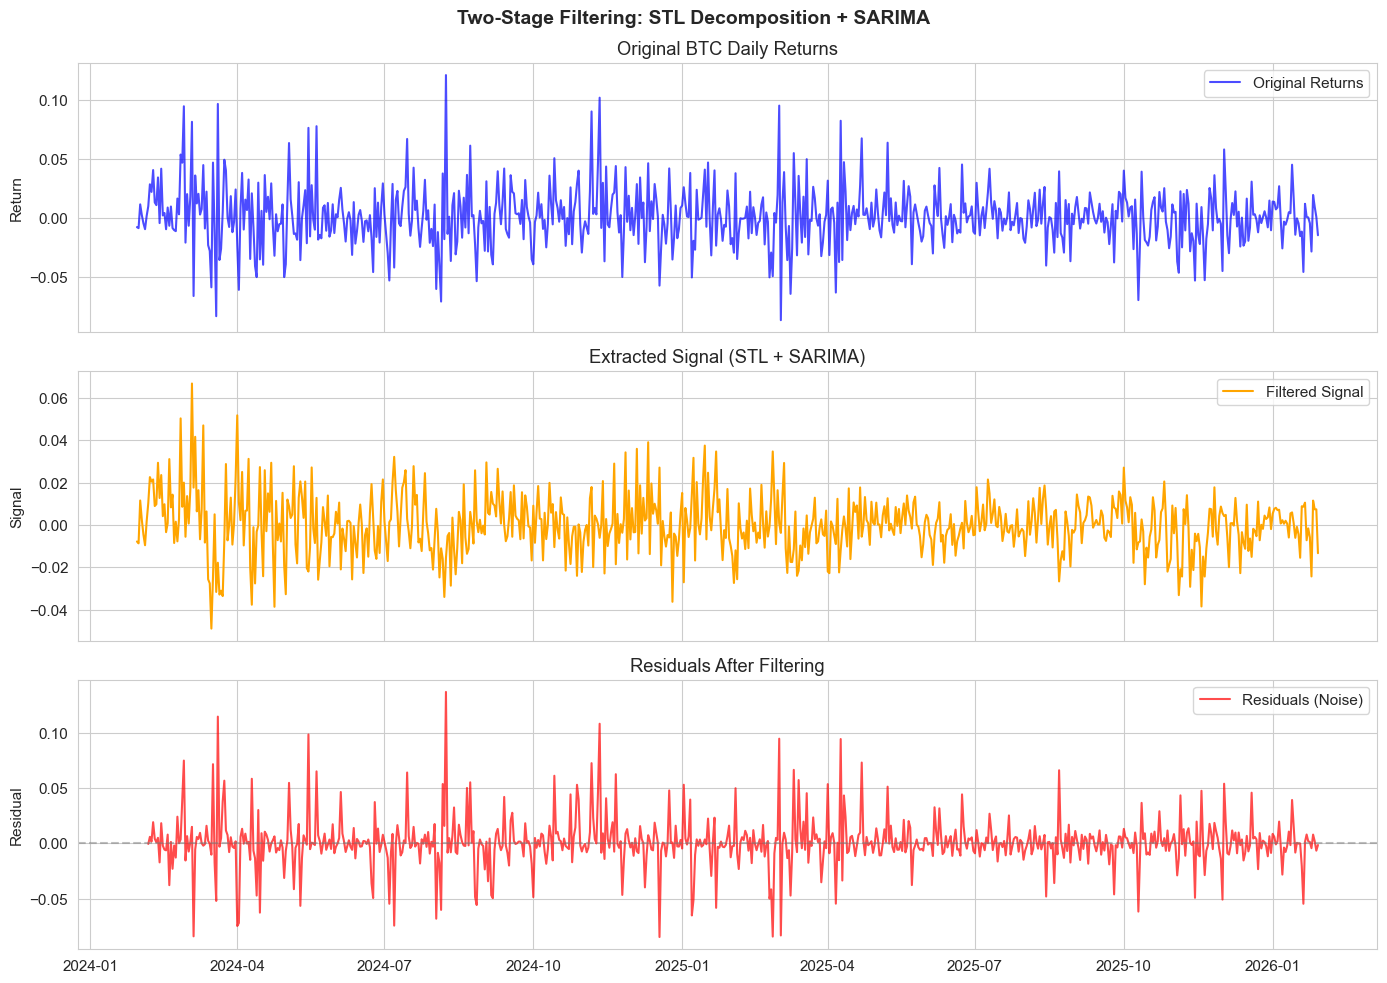

In [14]:
# ── Time Series Filtering: 3-Panel Decomposition ──
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(btc_returns, label='Original Returns', color='blue', alpha=0.7)
axes[0].set_title('Original BTC Daily Returns')
axes[0].set_ylabel('Return')
axes[0].legend()

axes[1].plot(filtered, label='Filtered Signal', color='orange', linewidth=1.5)
axes[1].set_title('Extracted Signal (STL + SARIMA)')
axes[1].set_ylabel('Signal')
axes[1].legend()

axes[2].plot(residuals, label='Residuals (Noise)', color='red', alpha=0.7)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Residuals After Filtering')
axes[2].set_ylabel('Residual')
axes[2].legend()

plt.suptitle('Two-Stage Filtering: STL Decomposition + SARIMA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The top panel shows raw BTC daily returns — noisy with no obvious pattern. The middle panel shows the extracted signal after two-stage filtering (STL + SARIMA): this represents the underlying dynamics stripped of noise. The bottom panel shows the residuals, which should ideally look like white noise if the filter captured all systematic structure. The Ljung-Box test above confirmed the residuals are indeed white noise, validating the filter quality.

---
## 4. Mixed-Frequency Imputation (MICE)

The `MixedFrequencyImputer` aligns data of different frequencies (daily, weekly, monthly) to a common quarterly grid using MICE (Multiple Imputation by Chained Equations).

### 4.1 Prepare Mixed-Frequency Data

In [15]:
from timeseries_toolkit.preprocessing import MixedFrequencyImputer, align_to_quarterly

# Create mixed-frequency inputs:
# - Daily: BTC closing price
# - Daily: SPY closing price
# These will be aligned to a quarterly grid.

# Build quarterly target index
quarterly_idx = pd.date_range(
    start=btc_close.index[0],
    end=btc_close.index[-1],
    freq='QE'
)

print(f'Quarterly target dates: {len(quarterly_idx)}')
print(f'From {quarterly_idx[0].date()} to {quarterly_idx[-1].date()}')

# Align each series to quarterly
btc_q = align_to_quarterly(btc_close, quarterly_idx, aggregation='last')
spy_q = align_to_quarterly(spy_close, quarterly_idx, aggregation='last')

print(f'\nBTC quarterly: {len(btc_q)} points')
print(f'SPY quarterly: {len(spy_q)} points')

pd.DataFrame({'BTC-USD': btc_q, 'SPY': spy_q})

Quarterly target dates: 8
From 2024-03-31 to 2025-12-31

BTC quarterly: 8 points
SPY quarterly: 8 points


,BTC-USD,SPY
2024-03-31,71333.648438,512.037109
2024-06-30,62678.292969,534.459656
2024-09-30,63329.500000,565.198181
2024-12-31,93429.203125,579.277466
2025-03-31,82548.914062,554.560486
2025-06-30,107135.335938,614.326477
2025-09-30,114056.085938,664.217285
2025-12-31,87508.828125,681.919983


### 4.2 Run MICE Imputation

In [16]:
# Create a dataset with intentional gaps for imputation demo
btc_with_gaps = btc_close.copy()
# Introduce ~5% missing values
np.random.seed(42)
gap_mask = np.random.random(len(btc_with_gaps)) < 0.05
btc_with_gaps[gap_mask] = np.nan
print(f'Introduced {gap_mask.sum()} gaps in BTC series ({gap_mask.mean()*100:.1f}%)')

spy_with_gaps = spy_close.copy()
gap_mask2 = np.random.random(len(spy_with_gaps)) < 0.05
spy_with_gaps[gap_mask2] = np.nan
print(f'Introduced {gap_mask2.sum()} gaps in SPY series ({gap_mask2.mean()*100:.1f}%)')

# Run MICE
imputer = MixedFrequencyImputer(max_iter=5, random_state=42)
X_dict = {'BTC': btc_with_gaps, 'SPY': spy_with_gaps}
imputed = imputer.fit_transform(X_dict, target_index=quarterly_idx)

print(f'\nImputed DataFrame shape: {imputed.shape}')
print(f'Any NaN remaining: {imputed.isna().any().any()}')
imputed

Introduced 39 gaps in BTC series (5.3%)
Introduced 28 gaps in SPY series (5.6%)

Imputed DataFrame shape: (8, 10)
Any NaN remaining: False


,BTC_mean,BTC_std,BTC_min,BTC_max,BTC_last,SPY_mean,SPY_std,SPY_min,SPY_max,SPY_last
2024-03-31,58135.812632,10238.199647,42582.605469,73083.500000,71333.648438,494.451299,10.770997,471.230682,512.135010,512.037109
2024-06-30,65656.256450,3186.349001,58254.011719,71631.359375,62678.292969,512.579383,14.685115,484.715759,536.920837,534.459656
2024-09-30,60834.546375,3759.536368,53948.753906,68255.867188,63329.500000,542.412502,12.871991,508.101074,563.759949,562.942322
2024-12-31,82773.319439,15478.767881,60274.500000,106140.601562,93429.203125,580.723551,12.076394,559.327026,598.740051,579.277466
2025-03-31,93278.996967,7454.371852,78532.000000,106146.265625,82548.914062,582.088622,16.787636,549.467468,605.815796,554.560486
2025-06-30,98344.463511,9906.898204,76271.953125,111673.281250,107135.335938,567.494727,30.620949,492.193634,614.326477,614.326477
2025-09-30,114392.517578,3758.898950,105698.281250,123344.062500,114400.382812,637.601407,14.198321,614.127686,664.875366,664.217285
2025-12-31,99622.449826,12134.880621,84648.359375,124752.531250,87508.828125,674.127256,9.389449,650.607544,690.380005,681.919983


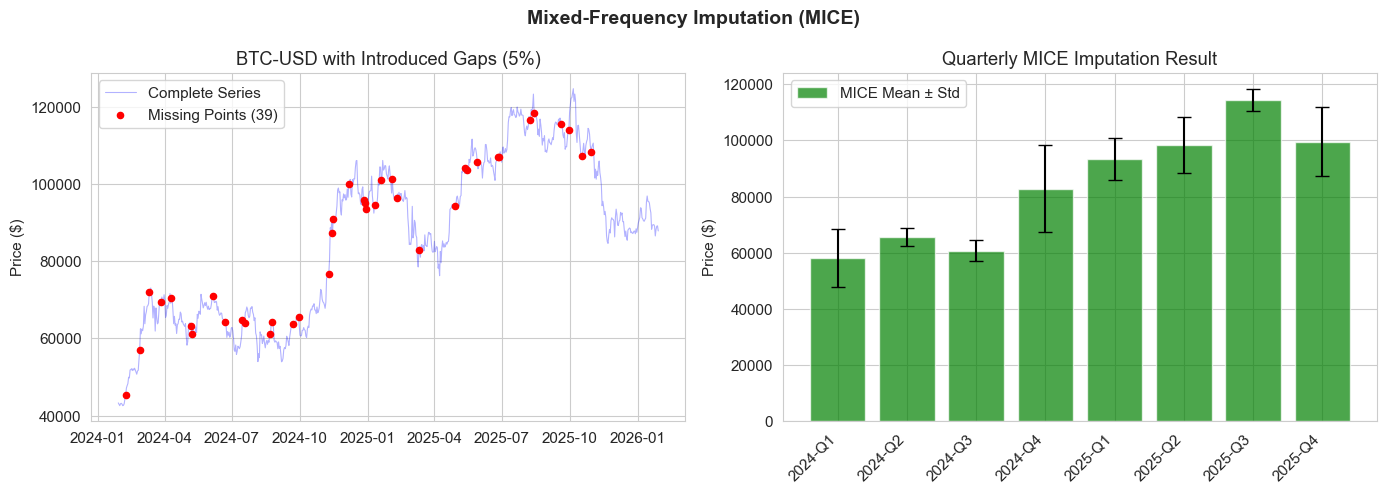

In [17]:
# ── MICE Imputation: Before vs After ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Daily series with NaN gaps highlighted
axes[0].plot(btc_close, color='blue', alpha=0.3, linewidth=0.8, label='Complete Series')
nan_dates = btc_with_gaps[btc_with_gaps.isna()].index
axes[0].scatter(nan_dates, btc_close.loc[nan_dates], color='red', s=20, zorder=5,
               label=f'Missing Points ({len(nan_dates)})')
axes[0].set_title('BTC-USD with Introduced Gaps (5%)')
axes[0].set_ylabel('Price ($)')
axes[0].legend()

# Right: Quarterly MICE output with error bars
quarters = imputed.index
q_labels = [f"{q.year}-Q{(q.month-1)//3+1}" for q in quarters]
x_pos = range(len(quarters))
axes[1].bar(x_pos, imputed['BTC_mean'], yerr=imputed['BTC_std'],
           color='green', alpha=0.7, capsize=5, label='MICE Mean ± Std')
axes[1].set_xticks(list(x_pos))
axes[1].set_xticklabels(q_labels, rotation=45, ha='right')
axes[1].set_title('Quarterly MICE Imputation Result')
axes[1].set_ylabel('Price ($)')
axes[1].legend()

plt.suptitle('Mixed-Frequency Imputation (MICE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The left panel shows the original daily BTC price series with ~5% of values randomly removed (red dots mark where data was missing). The right panel shows the result of MICE imputation aggregated to quarterly frequency — each bar represents the mean price for that quarter with error bars showing the standard deviation. MICE successfully handles the missing data and produces clean quarterly summaries suitable for mixed-frequency analysis.

---
## Summary

| Module | Key Class/Function | Purpose |
|--------|-------------------|--------|
| `fractional_diff` | `find_min_d_for_stationarity()`, `frac_diff_ffd()` | Stationarity with memory preservation |
| `filtering` | `TimeSeriesFilter` | Noise removal (STL + SARIMA) |
| `imputation` | `MixedFrequencyImputer`, `align_to_quarterly()` | Gap filling and frequency alignment |

All three preprocessing modules work together in the MarketIntelligence pipelines (see Notebook 04).